In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from numba import jit, autojit
from scipy.sparse import csc_matrix, dia_matrix, diags
from scipy.sparse.linalg import eigs, eigsh
from celluloid import Camera

x = np.linspace(-10,10,1001)

<IPython.core.display.Javascript object>


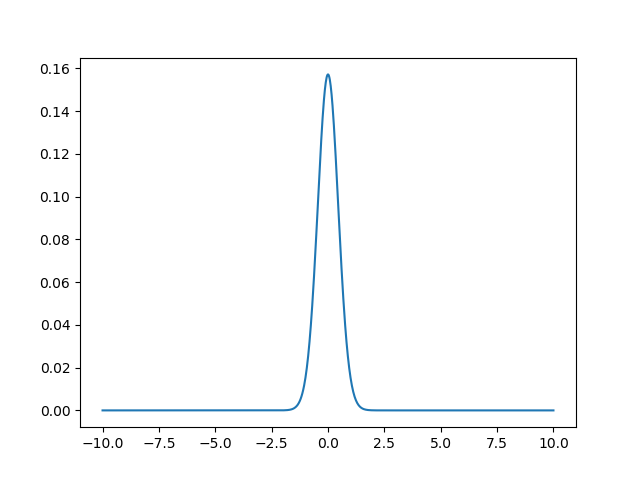

-92.8373330599041


In [37]:
# Initialise constants for the softcore potential:
v = 200# set =0 for particle in a box case
n = 2
b = 2


@np.vectorize
def potential_softcore(xk, t):
    numerator = -v
    denominator = (np.abs(xk)**n + b**n)**(1/n)
    return numerator/denominator

@np.vectorize
def potential_linear_with_time(xk, t):
    alpha = 10
    numerator = -v
    denominator = (np.abs(xk)**n + b**n)**(1/n)
    return numerator/denominator + alpha*t*xk

@np.vectorize
def potential_oscillating_with_time(xk,t):
    omega = 1
    numerator = -v
    denominator = (np.abs(xk)**n + b**n)**(1/n)
    return numerator/denominator + np.sin(t*omega)*xk*np.exp(2 - t**2)

"""
Choose which potential function to use:
"""
potential = potential_linear_with_time

def gen_diag_Hamiltonian(x_arr):
    
    dx2 = -1/(2*(np.abs(x_arr[0]-x_arr[1])**2))
    
    centre_diag = -(5/2)*np.ones_like(x_arr)*dx2
    one_off_diag = (4/3)*np.ones_like(x_arr[:-1])*dx2    
    two_off_diag = -(1/12)*np.ones_like(x_arr[:-2])*dx2
    
    H = diags([centre_diag,one_off_diag,one_off_diag,two_off_diag,two_off_diag],[0,1,-1,2,-2])
    return H

def gen_diag_V(x_arr, potential_func, t):
    V = potential_func(x_arr, t)
    return diags([V],[0])

H_without_V = gen_diag_Hamiltonian(x) 
H = H_without_V + gen_diag_V(x, potential, 0)


biggest_abs_val = 100
eig_vals,eig_vecs = eigsh(H, k=5, sigma=-biggest_abs_val)

plt.figure()
plt.plot(x,eig_vecs[:,0])
print(eig_vals[1])

In [41]:
dt = 1e-3

@jit
def time_evo_operator(eig_val, t):
    return np.exp(-1j*eig_val*t)

original_eigstate = eig_vecs[:,0]

evolve_o_eigstate_no_ext_n_times = lambda n: [original_eigstate * time_evo_operator(eig_vals[0], dt)**i for i in range(0,n)]

"""
6th order time propogation results:
"""

sixth_order_coeffs = np.array([-49/20, 6, -15/2, 20/3, -15/4, 6/5, -1/6])/dt

@autojit
def evolve_state(dt, previous_eigstates, coeffs, t):
    H = H_without_V + gen_diag_V(x, potential, t)
    evolved_part = (H*previous_eigstates[-1])
    new_eigstate = 1j*dt*evolved_part
    for i,c in enumerate(coeffs[1:]):
        new_eigstate -= c*previous_eigstates[-i-1]
    new_eigstate /= coeffs[0]
    return new_eigstate

previous_eigstates = evolve_o_eigstate_no_ext_n_times(6)
#print(previous_eigstates[0][4995:5005])

def time_step(t):
    global previous_eigstates
    new_eigstate = evolve_state(dt, previous_eigstates, sixth_order_coeffs, t)
    previous_eigstates.append(new_eigstate)
    del previous_eigstates[0]


<IPython.core.display.Javascript object>


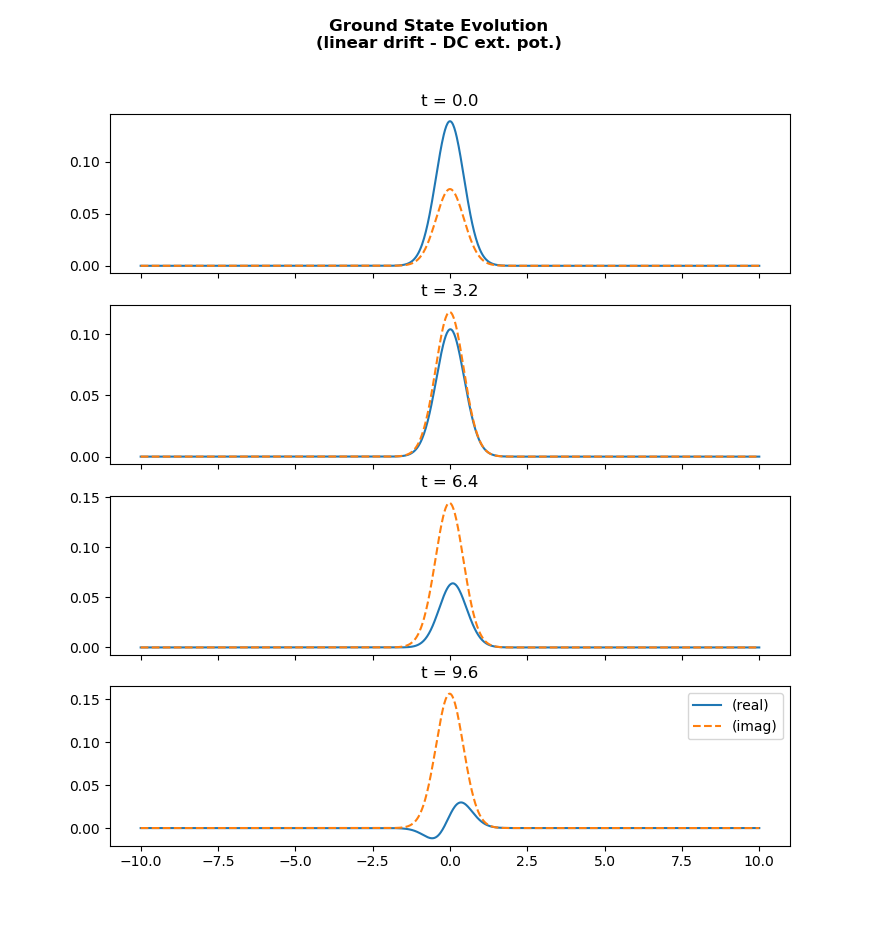

Text(0.5,0.98,'Ground State Evolution\n(linear drift - DC ext. pot.)')

In [42]:
"""
fig = plt.figure()
camera = Camera(fig)
t = 0
for i in range(100):
    plt.plot(x, previous_eigstates[-1].real, 'b')
    plt.plot(x, previous_eigstates[-1].imag, '--r')
    for j in range(700):
        t+=dt
        time_step(t)
    plt.title = 't = {}'.format(t)
    camera.snap()
"""

fig, [ax1,ax2,ax3,ax4] = plt.subplots(4,1, sharex=True)
ax = [ax1,ax2,ax3,ax4]
t = 0
for i in range(4):
    ax[i].plot(x, previous_eigstates[-1].real, label='(real)')
    ax[i].plot(x, previous_eigstates[-1].imag, '--', label='(imag)')
    ax[i].set_title('t = {}'.format(i*3200*dt))
    for j in range(3200):
        t+=dt
        time_step(t)
plt.legend()
plt.suptitle('Ground State Evolution\n(linear drift - DC ext. pot.)', fontweight='bold')

In [43]:
plt.savefig('TimeEvolutionGroundStateWithDCDrift.png', dpi=500)